# Пример нейросетки для генерации рекомендаций

## Тестовые данные IVI.ru

In [1]:
import pandas as pd

# загружаем данные
raw_watch = pd.read_csv('./test_task/content_watch.csv', sep = ',', usecols=[0,1]) # только пары user_id - item_id
print raw_watch.head(3)
print 'train samle len: {}\n{}'.format(raw_watch.shape[0], '-'*20)

# аггрегируем сессии смотрения пользователей
USER_SESSIONS = raw_watch.groupby('user_index')['item_id'].apply(list)
# важный момент - удаляем сессии, где меньше двух просмотров контента, т.к. на них нельзя обучится
USER_SESSIONS = USER_SESSIONS[USER_SESSIONS.apply(len) > 1]
print USER_SESSIONS.head(2)
print 'uniq users: {}'.format(USER_SESSIONS.shape[0])

   user_index     item_id
0  1677306600  2011099417
1  1677306600 -1495220568
2  1677306600  1642882038
train samle len: 743885
--------------------
user_index
-2147407952    [510527058, -549996512, -14855385, 6761694, 17...
-2147298847    [-14855385, -672834242, -177246609, 6761694, 1...
Name: item_id, dtype: object
uniq users: 72614


In [2]:
# вытаскиваем уникальные единицы контента (трейн + тест)
content = raw_watch[['item_id']]\
    .append(pd.read_csv('./test_task/test_set.csv', sep=',', usecols = ['item_id']), ignore_index = True)\
    .item_id
content = content.drop_duplicates()
content.reset_index(drop=True, inplace=True)
content_index = {y:x for x,y in content.to_dict().iteritems()} # генерируем индекс для базы контента
print 'Total films in sample: {}'.format(len(content_index))

Total films in sample: 7245


In [864]:
# определяем константы
USER_NUM = USER_SESSIONS.shape[0]

def get_item():
    # генерим тензоры из набора фильмов пользователя
    ind = np.random.randint(0,high = USER_NUM-1)
    ses = np.array(USER_SESSIONS.iloc[ind]) # сессия
    # заменяем фильмы в сессии на их индексы
    sample_session = np.array([content_index[i] for i in USER_SESSIONS.iloc[ind]])
    return Variable(torch.from_numpy(sample_session[:-1]).long()), Variable(torch.from_numpy(sample_session[1:]).long())

get_item()

## Model

In [155]:
import numpy as np
import time
#-- для RNN используем torch --
import torch
import torch.nn as nn
from torch.autograd import Variable
#----------------

In [865]:
# сетка
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, output_size):
        '''
        n_layers - число скрытых слоёв
        hidden_size - число нейронов в скрытом слое
        input_size == output_size - размер библиотеки контента
        '''
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_hidden_layers
        # архитектура сети
        self.encoder = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size, n_hidden_layers) 
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
# рекомендательная система
class NeuroHydra():
    def __init__(self, neural_network):
        ''' На вход принимаем модельку и 
        вектор доступного контента
        '''
        self.net = neural_network
        self.loss = 0
        self.all_losses = []
    
    def zero_state(self):
        self.net.zero_grad()
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, inp, target):
        # начальное состояние
        self.zero_state()
        #print inp.size()
        chunk_len = int(inp.size()[0])
        loss = 0
        # запускаем процесс обучения
        hidden = self.net.init_hidden()
        for c in range(chunk_len): # итерируем по чанкам
            output, hidden = self.net(inp[c], hidden) # encoder->GRU(LTSM ячейка)->decoder
            loss += self.criterion(input = output, target = target[c])
        loss.backward() # вычисляем градиент
        self.optimizer.step()
        return loss.data[0] / chunk_len # усредняем потери
        
    def evaluate(user_history = [7029], num_recommed=10, temperature=0.8):
        ''' Этап эксплуатации сети
        на вход получаем вектор фильмов пользователя user_history
        генерируем по ним num_recommed рекомендаций
        temperature - чем ниже, тем разнообразней рекомендации
        '''
        prime_input = torch.from_numpy(np.array(user_history)).long()
        predicted = np.array([])
        # "прогреваем" сетку историей смотрения юзера
        hidden = self.net.init_hidden()
        for p in prime_input[:-1]:
            _, hidden = self.net(p, hidden)
        inp = prime_input[-1]
        for p in range(num_recommed):
            output, hidden = self.net(inp, hidden)
            # нахлобучиваем софтмакс на полносвязный слой
            output_dist = output.data.view(-1).div(temperature).exp() 
            recommend = torch.multinomial(output_dist, 1)[0]
            predicted = np.append(predicted, recommend)
            inp = recommend
        return predicted

    def learn_model(self, lr, n_epoch):
        start = time.time()
        loss_avg = 0
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.n_epoch = n_epoch
        plot_every = 10
        for epoch in range(n_epoch):
            inp, target = get_item() # выдёргиваем случайного пользователя
            loss = self.train(inp, target)
            loss_avg += loss
            if epoch % plot_every == 0: # иногда обнуляем потери и смотри результат
                self.all_losses.append(loss_avg / plot_every)
                loss_avg = 0

## Обучаем модель

In [873]:
# параметры из nn_config можно подбирать
DATA_TYPE = 'films'
content_num = len(content_index)

nn_config = {'input_size': content_num,\
             'hidden_size' : 100,\
             'n_hidden_layers' : 2,\
             'output_size': content_num}
learn_config = { 'n_epoch' : 10000,\
                 'lr' : 0.005 }

rnn = RNN(**nn_config)
recommender = NeuroHydra(rnn)
recommender.learn_model(**learn_config)

### Обучение модели - смотри график потерь

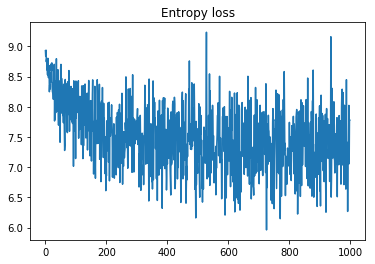

In [874]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.title('Entropy loss')
plt.plot(recommender.all_losses[1:])